In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
os.getenv('TEST')

'YES'

In [1]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from pprint import pprint

persist_directory = 'ignore/chroma/'
embedding_function = OpenAIEmbeddings()
vector_db = Chroma(embedding_function = embedding_function,
                   persist_directory=persist_directory)
print(vector_db._collection.count())

754


# Retrieval methods

### Basic semantic similarity search, finds k most similar queries

In [15]:
# query it
query = "What is the meaning of a Subscription economy? Give an example"
docs = vector_db.similarity_search(query, k=2)
print(f'Number of matches: {len(docs)}')
for doc in docs:
    pprint(doc.page_content)

Number of matches: 2
('the goal of business should be to start with the wants and needs of a '
 'particular customer base, then create a service that delivers ongoing value '
 'to those customers. The idea was to turn customers into subscribers in order '
 'to develop recurring revenue. I called the context for this change the '
 'Subscription Economy. Oh man, did I get a lot of crap for that article. '
 'There were comments like: Do you really think we don’t get it, Tien? That we '
 'don’t understand the difference between a product and a')
('the rapid ascent of the Subscription Economy. As I’ve mentioned previously, '
 'by 2020, we should expect to see more than 80 percent of software providers '
 'shift to subscription-based business models (according to Gartner) and 50 '
 'percent of the world’s largest enterprises depend on digitally enhanced '
 'products, services, and experiences. Recurring revenue-based business models '
 'are not new, but they have exploded in recent years owi

### Maximum marginal relevance, finds fetch_k most similar results, then get k most diverse results

In [16]:
query = "What is the meaning of a Subscription economy? Give an example"
docs = vector_db.max_marginal_relevance_search(query, k=2, fetch_k=4)
print(f'Number of matches: {len(docs)}')
for doc in docs:
    pprint(doc.page_content)

Number of matches: 2
('the goal of business should be to start with the wants and needs of a '
 'particular customer base, then create a service that delivers ongoing value '
 'to those customers. The idea was to turn customers into subscribers in order '
 'to develop recurring revenue. I called the context for this change the '
 'Subscription Economy. Oh man, did I get a lot of crap for that article. '
 'There were comments like: Do you really think we don’t get it, Tien? That we '
 'don’t understand the difference between a product and a')
('Today the whole world runs “as a service”: transportation, education, media, '
 'health care, connected devices, retail, industry. Subscriptions themselves, '
 'of course,aren’t new. The most basic definition of a subscription is simply '
 'a piece of writing beneath a document (sub script): a name, a note, an '
 'addendum. When two parties are involved, that constitutes a mutual '
 'agreement, an accord, a relationship. As a business model, subs

### Self query

# Question answering with semantic search + LLM

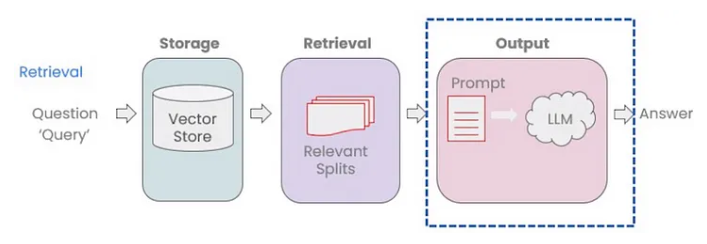

### Without using a customized prompt

In [8]:
model_name = 'gpt-3.5-turbo-1106'
llm = ChatOpenAI(model_name=model_name, temperature=0)


qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever = vector_db.as_retriever(),
    return_source_documents=True
)

query = "What are major topics for this book?"
result = qa_chain({"query": query})
pprint(result["result"])

print('\n----------Printing source documents-----------------\n')
print(f"Total of {len(result['source_documents'])} sources")
for document in result['source_documents']:
    pprint(document.page_content)
    print()

('The major topics for this book include how subscriptions are transforming '
 'different industries, tactical and operational details on applying the '
 'subscription model across all aspects of a company, industry benchmarks, '
 'relevant case studies, best practices, and guidance on transitioning a '
 'traditionally product-based company to a subscription-based revenue model.')

----------Printing source documents-----------------

Total of 4 sources
('for a basic playbook on making the shift to recurring revenue. While '
 'subscriptions have been getting a huge amount of press coverage lately, I’m '
 'going to give you the most important material, the stone tablets. In Part 1 '
 'of this book we’ll explore how subscriptions are transforming several '
 'different industries, and in Part 2 we’ll dig into more tactical, '
 'operational details about how to apply the subscription model across every '
 'aspect of your company. Here are some of the topics I’ll be')

('businesses I want t

In [9]:
query = "Did the author explain his story?"
result = qa_chain({"query": query})
pprint(result["result"])

print('\n----------Printing source documents-----------------\n')
print(f"Total of {len(result['source_documents'])} sources")
for document in result['source_documents']:
    pprint(document.page_content)
    print()

('Yes, the author explained the importance of starting with a foundational '
 'thesis or a bigger reason to exist when telling a business story. The author '
 'also emphasized the significance of understanding the context of the company '
 'within the broader commercial world before delving into the product story.')

----------Printing source documents-----------------

Total of 4 sources
('companies (especially ones here in Silicon Valley) have a pretty good grasp '
 'of the first two stories. They know what they’re selling, and who’s buying. '
 'They have nice scrolling websites filled with all sorts of product features '
 'and client case studies. But lots of them are missing a foundational thesis. '
 'A bigger reason to exist. They don’t have a why (much less a why now ). And '
 'that’s the story you should really be starting with. In a perfect world, '
 'these stories are actually heard in a')

('We were excited about our business. Things were going well, and we had an '
 'aggress

### With a chained prompt

In [10]:
model_name = 'gpt-3.5-turbo-1106'
model = ChatOpenAI(model_name=model_name, temperature=0)

# Build prompt
template = """Use the following pieces of context to answer the question at the end. \
If you don't know the answer, just say that you don't know, don't try to make up an answer. \
Use three sentences maximum. Keep the answer as concise as possible. 
Context: {context}
Question: {question}
Helpful Answer:"""
qa_chain_prompt = PromptTemplate.from_template(template)

qa_chain = RetrievalQA.from_chain_type(
    model,
    retriever=vector_db.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_chain_prompt}
)

query = "What are major topics for this book?"
result = qa_chain({"query": query})
pprint(result["result"])

print('\n----------Printing source documents-----------------\n')
print(f"Total of {len(result['source_documents'])} sources")
for document in result['source_documents']:
    pprint(document.page_content)
    print()

# Prompting without  customizing the prompt
('The major topics for this book include how subscriptions are transforming '
 'different industries, tactical and operational details on applying the '
 'subscription model across all aspects of a company, industry benchmarks, '
 'relevant case studies, best practices, and guidance on transitioning a '
 'traditionally product-based company to a subscription-based revenue model.')

('The major topics for this book include the transformation of industries '
 'through subscriptions, tactical details on applying the subscription model, '
 'industry benchmarks, relevant case studies, and best practices for '
 'enterprise businesses transitioning to a recurring revenue model.')

----------Printing source documents-----------------

Total of 4 sources
('for a basic playbook on making the shift to recurring revenue. While '
 'subscriptions have been getting a huge amount of press coverage lately, I’m '
 'going to give you the most important material, the stone tablets. In Part 1 '
 'of this book we’ll explore how subscriptions are transforming several '
 'different industries, and in Part 2 we’ll dig into more tactical, '
 'operational details about how to apply the subscription model across every '
 'aspect of your company. Here are some of the topics I’ll be')

('businesses I want to note that this isn’t just a Silicon Valley story, nor '
 'is this a Silicon Valley bo